In [110]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

### Data Loading

In [111]:
data_ = pd.read_csv("../data/FilteredData.csv")

In [112]:
def SingleAtomRemover(x):
    singleAtom = ["[Kr]","[Ne]","C","[Li]","O","[Ar]",'[Xe]']
    if x in singleAtom:
        return 1
    else: 
        return 0  

In [113]:
data = data_[["Structure","BBB+/BBB-"]]

In [114]:
data.replace({"BBB+":1,"BBB-":0},inplace=True)

In [115]:
data.rename(columns={"Structure":"SMILES","BBB+/BBB-":"LABELS"},inplace=True)

In [116]:
data["Isit"] = data["SMILES"].apply(SingleAtomRemover)

In [117]:
### Remove single element
data.drop(data[data["Isit"] == 1].index,inplace=True)

In [118]:
data.to_csv(r"raw/data.csv")

In [137]:
from torch_geometric.data import InMemoryDataset, download_url, Dataset, Data
from dgllife.utils import (CanonicalAtomFeaturizer,
                           one_hot_encoding,
                           atom_implicit_valence_one_hot,
                           atom_total_degree_one_hot,
                           atomic_number_one_hot,
                           atom_hybridization_one_hot,
                           atom_is_in_ring_one_hot,
                           atom_is_aromatic_one_hot,
                          )
from rdkit import Chem

class BBBDataset(Dataset): ### All dataset will store in RAM
    
    def __init__(self,root,transform = None, pre_transform=None,pre_filter=None,one_hot=False):
        
        """
        root: where the dataset shoul be stored. The folder will split into raw_dir (downloaded dataset)
        and processed_dir (processed data).

        """
        self.one_hot = one_hot
        super().__init__(root, transform, pre_transform, pre_filter)
        
    
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        dataArray = self.data[["SMILES","LABELS"]].to_numpy().squeeze()
        
        j = 0
        for i in tqdm(dataArray):
            processed_data = self.smiles2graph(*i,one_hot=self.one_hot)
            
            nodes_feats = processed_data["X"]
            label = processed_data["Y"]
            edge_feats = processed_data["E"]
            adj_mat = processed_data["A"]
            smiles = processed_data["SMILES"]
            
            
            ### create data object
            data = Data(x=nodes_feats,edge_index=adj_mat,edge_attr=edge_feats,y=label,smiles=smiles)
            
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def smiles2graph(self, smiles,label,one_hot=False):
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            raise("Smiles not parsed by rdkit")

        adj_matrix = GetAdjacencyMatrix(mol) ### Adjacency matrix
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo,(2,-1))
        
        if one_hot:
            valence =[]
            degree = []
            atoms =  []
            hybrid = []
            mass =   []
            aromatic = []
            for idx,atom in enumerate(mol.GetAtoms()):
                valence.append(atom_implicit_valence_one_hot(atom))## Implicit valence
                degree.append(atom_total_degree_one_hot(atom))## total degree
                atoms.append(atomic_number_one_hot(atom))## atomic Number
                hybrid.append(atom_hybridization_one_hot(atom))## Hybridization
                mass.append([atom.GetMass()])## Mass(scalar)
                aromatic.append(atom_is_aromatic_one_hot(atom)) ## aromatic
                
            features  = torch.cat([torch.tensor(valence),
                                  torch.tensor(degree),
                                  torch.tensor(atoms),
                                  torch.tensor(hybrid),
                                  torch.tensor(aromatic),
                                  torch.tensor(mass)],axis=1)
            
        else:
            
            features = np.zeros((mol.GetNumAtoms(),5),) ### Feature Matrix
            for idx,atom in enumerate(mol.GetAtoms()):
                features[idx,0] = atom.GetAtomicNum()
                features[idx,1] = atom.GetDegree()
                #feature_array[idx,2] = atom.GetFormalCharge()
                features[idx,2] = atom.GetHybridization()
                features[idx,3] = atom.GetExplicitValence()
                features[idx,4] = atom.GetMass()
           
        label_array = torch.tensor([0]) if label == 0 else torch.tensor([1])
        
#         if label == 0:
#             label_array = torch.tensor([0])
#         else:
#             label_array = torch.tensor([1])

        all_edge_feats = []
        for bond in mol.GetBonds():
            Edge_feature = []
            # Feature 1: Bond type (as double)
            Edge_feature.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            Edge_feature.append(bond.IsInRing())
            # Append edget features to matrix (twice, per direction)
            all_edge_feats += [Edge_feature, Edge_feature]

        all_edge_feats = np.asarray(all_edge_feats)

        return {"A": torch.tensor(coo,dtype=torch.long),
               "X": torch.tensor(features,dtype=torch.float32),
               "Y":torch.tensor(label_array,dtype=torch.float32),
                "E":torch.tensor(all_edge_feats,dtype=torch.float32),
                "SMILES":smiles}
    
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [138]:
dataset = BBBDataset(root=".",one_hot=True)

Processing...
100%|█████████████████████████████████████████████████████████████████████████████| 3330/3330 [00:07<00:00, 462.35it/s]
Done!


### Applying PyG GCN With One-Hot encoded Features
___

In [139]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [140]:
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class PyGCN(torch.nn.Module):
    
    def __init__(self,num_node_features):
        
        super().__init__()
        self.num_node_features = num_node_features ### Node input size
        
        self.conv_1 = GCNConv(-1,64,improved=True) ### First layer convulation
        self.conv_2 = GCNConv(64,32) ### Second layer convulation
        self.conv_3 = GCNConv(32,16) ### Third layer convulation
        
        ## Two linear layer
        self.fc_1  = Linear(16,8)
        self.fc_2  = Linear(8,1)
       
            
    def forward(self,data,):
        
        batch, x,edge_index,edge_attr,y,smiles  = data.batch, data.x, data.edge_index, data.edge_attr,data.y, data.smiles
        
        ## Graph convulations
        x = F.relu(self.conv_1(x,edge_index)) 
        x = F.relu(self.conv_2(x,edge_index))
        x = F.relu(self.conv_3(x,edge_index))
        ## Readout layer
        x = global_mean_pool(x,batch)
        
        ### Final classifier
        x = F.relu(self.fc_1(x))
        x = F.sigmoid(self.fc_2(x))
    
        
        return x        

In [141]:
from torch.utils.data import random_split
### Splitting of data
train_set, valid_set, test_set = random_split(dataset,[2000,1000,330]) ## 60% train, 30% valid, 10 % test
trainloader = DataLoader(train_set,shuffle=True,batch_size=32)
validloader = DataLoader(valid_set, shuffle=True,batch_size=32)
testloader = DataLoader(test_set, shuffle=True,batch_size=32)

In [142]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = PyGCN(num_node_features=5)

### initialize an optimizer with someparameters
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001,momentum=0.9,)

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

PyGCN(
  (conv_1): GCNConv(-1, 64)
  (conv_2): GCNConv(64, 32)
  (conv_3): GCNConv(32, 16)
  (fc_1): Linear(in_features=16, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=1, bias=True)
)

In [143]:
def train():
    net.train()
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        train_loss.append(loss)
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
    return torch.sum(torch.tensor(train_loss))/len(trainloader)
        
        

In [144]:
def test(loader):
    net.eval()
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
    return torch.sum(torch.tensor(val_loss))/len(loader)

In [145]:
epoch_loss = []
valida_loss = []
test_loss = []
for epoch in range(1,50):
    train_loss = train()
    train_acc = test(trainloader)
    val_acc = test(validloader)
    test_acc = test(testloader)
    epoch_loss.append(train_loss)
    valida_loss.append(val_acc)
    test_loss.append(test_acc)
    #print(train_loss)
    print(f'Epoch: {epoch:03d}, Train loss: {train_acc:.4f}, val loss: {val_acc:.4f},test loss: {test_acc:.4f}')

Epoch: 001, Train loss: 0.6651, val loss: 0.6582,test loss: 0.6990
Epoch: 002, Train loss: 0.6507, val loss: 0.6470,test loss: 0.6898
Epoch: 003, Train loss: 0.6473, val loss: 0.6518,test loss: 0.6651
Epoch: 004, Train loss: 0.6362, val loss: 0.6354,test loss: 0.6658


KeyboardInterrupt: 

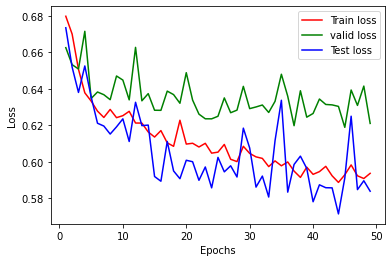

In [135]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,50)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,50)],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
plt.plot([i for i in range(1,50)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [136]:
print(f"Training loss:   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss: Mean: {torch.tensor(valida_loss).mean()}   std: {torch.tensor(valida_loss).std()}")
print(f"Test loss:       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss:   Mean: 0.6112170219421387   std: 0.019360549747943878
validation loss: Mean: 0.6355429887771606   std: 0.011122460477054119
Test loss:       Mean: 0.6054069995880127   std: 0.02176579274237156
